# Map Area: Porto, Portugal

https://s3.amazonaws.com/metro-extracts.mapzen.com/porto_portugal.osm.bz2

In [116]:
%matplotlib inline

import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint
import codecs
import json
import os
from pymongo import MongoClient
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

In [117]:
OSMFILE = "porto_portugal.osm"

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
double_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*:([a-z]|_)*$')

In [118]:
street_type_re = re.compile(r'^\b\S+\.?', re.IGNORECASE)

changes = {'Rua Dragoes Sandinenses': u'Rua Drag\xe3es Sandinenses',
           'Rua S. Pedro': u'Rua S\xe3o Pedro'}

expected = ["Rua", "Avenida", "Alameda", "Caminho", "Largo", "Cais", "Campo", u'Cal\xe7ada', "Ciclovia",
            "Esplanada", "Estrada", "Ladeira", "Lugar", "Praceta", "Travessa", "Via", "Viela", 
            "Zona", "Mercado"]

# UPDATE THIS VARIABLE           
mapping = {
    '25': 'Rua 25',
    'Av': 'Avenida',
    'Av.': 'Avenida',
    'Brito': 'Rua Brito',
    'Calcada': u'Cal\xe7ada',
    'Costa': 'Rua Costa',
    'EN' : 'Estrada Nacional',
    'Nacional' : 'Estrada Nacional', 
    'Nossa' : 'Rua Nossa',
    'Padre' : 'Rua Padre',
    'Paramos' : 'Rua Paramos',
    u'Pra\xe7a' : 'Praceta',
    u'Pra\xe7eta': 'Praceta',
    u'P\xe1tio' : u'P\xe1tio',
    'R' : 'Rua',
    'R.': 'Rua',
    'RUA': 'Rua',
    'R.S.Pedro': 'Rua S. Pedro',
    u'Urbaniza\xe7\xe3o': u'Urbaniza\xe7\xe3o',
    'da': 'Rua da',
    'do' : 'Rua do',
    'Medas': 'Rua Medas',
    'Largo': 'Largo',
    'Rua' : 'Rua',
    'Avenida': 'Avenida',
    'Alameda': 'Alameda',
    'Caminho': 'Caminho',
    'Cais': 'Cais',
    'Campo': 'Campo',
    'Ciclovia': 'Ciclovia',
    'Esplanada': 'Esplanada',
    'Estrada': 'Estrada',
    'Ladeira': 'Ladeira',
    'Lugar': 'Lugar',
    'Praceta' : 'Praceta',
    'Travessa': 'Travessa',
    'Via': 'Via', 
    'Viela': 'Vieta',
    'Zona' : 'Zona',
    'Mercado': 'Mercado',
    u'Cal\xe7ada': u'Cal\xe7ada'}

#pprint.pprint(mapping)

In [119]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    postcodes = set()
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
                if is_postcode(tag):
                    postcodes.add(tag.attrib['v'])
                
    elem.clear() 
    return (street_types, postcodes)

def update_name(name, mapping):
    '''Update each street name with the replacement ending in the mapping dictionary'''
    match = re.search(street_type_re,name)
    name = re.sub(street_type_re,mapping[match.group()],name).title()
    return name

(st_types, pcodes) = audit(OSMFILE)

In [120]:
#pprint.pprint(dict(st_types))
#print pcodes

print "Number of types: {}".format(len(dict(st_types)))

Number of types: 22


In [121]:
for st_type, ways in st_types.iteritems():
    #print "'{}': '{}'".format(st_type.encode('utf-8'), st_type.encode('utf-8'))
    for name in ways:
        better_name = update_name(name, mapping)
        print name, "=>", better_name

RUA DRAGOES SANDINENSES => Rua Dragoes Sandinenses
RUA Central de Gens => Rua Central De Gens
RUA CONDE FERREIRA => Rua Conde Ferreira
Costa Padrão => Rua Costa Padrão
Nacional 1 => Estrada Nacional 1
Nacional 1/IC2 => Estrada Nacional 1/Ic2
25 Abril => Rua 25 Abril
Medas => Rua Medas
Av. da Pedra Verde => Avenida Da Pedra Verde
Av. 24 => Avenida 24
Av. Pedra Verde => Avenida Pedra Verde
Av. Principal => Avenida Principal
Av. Menéres => Avenida Menéres
Paramos => Rua Paramos
Praçeta Professor Sampaio => Praceta Professor Sampaio
EN 204/5 => Estrada Nacional 204/5
Padre Ricardo Neto => Rua Padre Ricardo Neto
do Sol => Rua Do Sol
da fonte => Rua Da Fonte
Praça da Liberdade => Praceta Da Liberdade
Praça Vasco da Gama => Praceta Vasco Da Gama
Praça do Almada => Praceta Do Almada
Praça Mouzinho de Albuquerque => Praceta Mouzinho De Albuquerque
Praça Dom Afonso V => Praceta Dom Afonso V
Praça dos Poveiros => Praceta Dos Poveiros
Praça da Ribeira => Praceta Da Ribeira
Praça Coronel Pacheco =>

In [122]:
def shape_element(element):
    """Takes a top level element or tag such as way, node, etc and iterates through each element
    and 2nd level tag (if applicable). Returns one cleaned
    node (could be a 'way' as well) which is a dictionary of all the fields later 
    to be converted to a JSON document.    
    """
    if element.tag == "node" or element.tag == "way":
        node = {} 
        #1st level tags
        node['type'] = element.tag          
        for attrName, attrValue in element.attrib.items(): #iterate through each 1st level attr of 'node' or 'way'
            if attrName == "lat":
                if 'pos' not in node.keys():
                    node['pos']= [float(1),float(1)]
                node['pos'][0] = float(attrValue)
                continue
            if attrName == "lon":
                if 'pos' not in node.keys():
                    node['pos']= [float(1),float(1)]
                node['pos'][1] = float(attrValue)
                continue
            if attrName == "" or attrValue == "": #avoid importing any blank keys or values
                continue
            if attrName == 'id': #id is a first level attribute
                node['_id'] = attrValue #doing this ensures this _id replaces ObjectId in mongoDB when importing
                continue
            node[attrName] = attrValue
            
        #2nd level tags
        ndtags = element.findall("./*")
        for ndtag in ndtags: #iterate through each 2nd level tag
            kvalue, vvalue, refvalue = ['','','']
            for aName, aValue in ndtag.attrib.items():  
                if aName == "k":
                    kvalue = aValue
                if aName == "v":
                    vvalue = aValue
                if aName == "ref":
                    refvalue = aValue
            if kvalue == 'type': 
                continue
            dc,pc,lc = [double_colon.search(kvalue),problemchars.search(kvalue),lower_colon.search(kvalue)]
        
        #if second level tag "k" value contains problematic characters, it should be ignored
            if vvalue in changes: 
                vvalue = changes[vvalue]
            if kvalue.startswith("addr:"):
                if kvalue == "addr:street": 
                    vvalue = update_name(vvalue, mapping)         
                if 'address' not in node.keys():              
                    node['address'] = {}
                node['address'][kvalue.split("addr:")[1]] = vvalue          
                continue
            if lc:  
                kvalue = re.sub(":"," ",kvalue) #replace the colon with an space
                node[kvalue] = vvalue
                continue
            if kvalue.startswith("geobase:"):             
                kvalue = kvalue.split("geobase:")[1] 
                node[kvalue] = vvalue
                continue                
            if kvalue == "" or vvalue == "": #avoid blank fields and values
                continue
            if element.tag == "way" and refvalue != "" : 
                if "node_refs" not in node.keys():
                    node['node_refs'] = []
                node["node_refs"].append(refvalue)
            node[kvalue] = vvalue
        return node
    else:
        return None

In [123]:
def process_map(file_in, pretty = False):    
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    counter = 0 #added counter to show status when creating json file
    with codecs.open(file_out, "w") as fo:        
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            counter += 1
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    print counter
    return data
      
data = process_map(OSMFILE, False)

1965653


#### Insert into Mongodb

In [126]:
client = MongoClient('mongodb://localhost:27017/')
db = client.p3

In [128]:
db.porto.insert_many(data)

In [129]:
db.porto.find()

## Problems encountered in the map

The Porto map has a main problem:

- Over-abbreviated street names (“R.”)
- Inconsistency due to the Portuguese language (for instance, c vs ç). See the changes in the variable 'changes' of the python code.

I have not found any problem with postal codes. 

## Data Overview

In [130]:
file_out = "{0}.json".format(OSMFILE)
print ">>> File Sizes <<<"
print "porto_portugal.osm      ... {}MB".format(os.path.getsize(OSMFILE) >> 20)
print "porto_portugal.osm.json ... {}MB".format(os.path.getsize(file_out) >> 20)

print "\n\n>>> Number of Documents <<<"
print db.porto.count()

print "\n\n>>> Number of Nodes <<<"
print db.porto.find({"type":"node"}).count()

print "\n\n>>> Number of Ways <<<"
print db.porto.find({"type":"way"}).count()

>>> File Sizes <<<
porto_portugal.osm      ... 143MB
porto_portugal.osm.json ... 141MB


>>> Number of Documents <<<
778496


>>> Number of Nodes <<<
675233


>>> Number of Ways <<<
103263


In [131]:
print "\n\n>>> Number of Unique Users <<<"
print len(db.porto.distinct("user"))



>>> Number of Unique Users <<<
895


#### Top Contributing Users

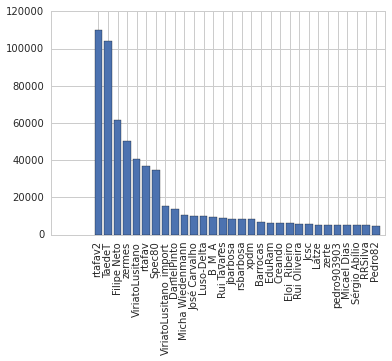

In [132]:
r = db.porto.aggregate( [
        { "$group":
             {"_id":"$user", 
              "count": { "$sum":1 }
             }
        }, 
        { "$sort": {"count": -1 }
        },
        { "$limit": 30 }
    ])

lres = list(r)
xs = [x['_id'] for x in lres]
ys = [x['count'] for x in lres]

plt.bar(range(len(xs)), ys, align='center')
plt.xticks(range(len(xs)), xs)
plt.setp(plt.xticks()[1], rotation=90)

plt.show()

#### Number of users appearing only once (having 1 post)

In [133]:
rr = db.porto.aggregate( [
        {"$group": 
             {"_id": "$user", 
              "count": { "$sum":1 }
             }
        }, 
        {"$group":
             {"_id":"$count", 
              "num_users":{"$sum":1}
             }
        }, 
        {"$sort":{"_id":1}
        }, 
        { "$limit":1 } ])

users = list(rr)[0]['num_users']
print "Users contributing only once: {}".format(users)
print "Percentage of users: ({0:.2f}%)".format((float(users) / len(db.cities.distinct("user")) * 100))

Users contributing only once: 130
Percentage of users: (14.46%)


## Other ideas about the dataset: exploring the dataset

In [137]:
amenities = db.porto.aggregate( [
        { "$match":
             {"amenity":{"$exists":1}} 
        },
        { "$group": 
             {"_id":"$amenity",
              "count": {"$sum":1}
             }
        }, 
        { "$sort": {"count": -1 }}, 
        {"$limit":10}])

print list(amenities)

[{u'count': 1469, u'_id': u'parking'}, {u'count': 764, u'_id': u'cafe'}, {u'count': 610, u'_id': u'restaurant'}, {u'count': 409, u'_id': u'school'}, {u'count': 351, u'_id': u'bench'}, {u'count': 346, u'_id': u'place_of_worship'}, {u'count': 260, u'_id': u'bank'}, {u'count': 251, u'_id': u'fuel'}, {u'count': 232, u'_id': u'pharmacy'}, {u'count': 185, u'_id': u'parking_entrance'}]


#### Being in Porto, Portugal, we expect the biggest religion to be Christian, but is this really the case? 

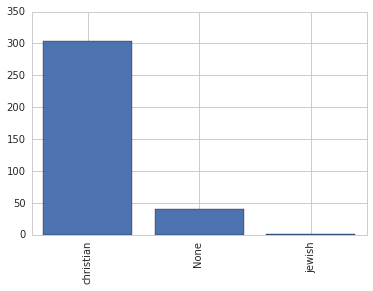

In [142]:
religion = db.porto.aggregate( [
        {"$match":{"amenity":{"$exists":1}, "amenity":"place_of_worship"}},
        {"$group":{"_id":"$religion", "count":{"$sum":1}}},
        {"$sort":{"count":-1}}, {"$limit":10}])

lres = list(religion)
xs = [x['_id'] for x in lres]
ys = [x['count'] for x in lres]

plt.bar(range(len(xs)), ys, align='center')
plt.xticks(range(len(xs)), xs)
plt.setp(plt.xticks()[1], rotation=90)

plt.show()

Came as a surprise only two listed religions, and a few None. This suggests that the data may is incomplete. 

#### What about cuisine?

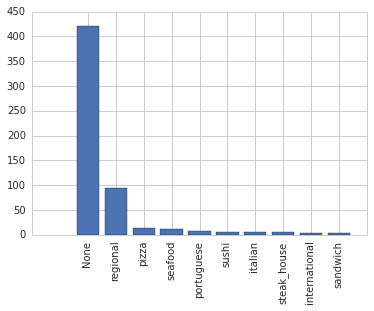

In [146]:
cuisine = db.porto.aggregate([{"$match":{"amenity":{"$exists":1}, "amenity":"restaurant"}}, 
                   {"$group":{"_id":"$cuisine", "count":{"$sum":1}}},        
                   {"$sort":{"count":-1}}, {"$limit":10}])

lres = list(cuisine)
xs = [x['_id'] for x in lres]
ys = [x['count'] for x in lres]

plt.bar(range(len(xs)), ys, align='center')
plt.xticks(range(len(xs)), xs)
plt.setp(plt.xticks()[1], rotation=90)

plt.show()

The high number of Nones suggests that the data is incomplete.

## Conclusions

After this review of the data it’s obvious that the Porto area is incomplete, despite the little problems with the data. 